<a href="https://colab.research.google.com/github/odie2630463/pyro_tutorial/blob/master/Temperature_Sensor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyro-ppl seaborn

In [0]:
import numpy as np
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.poutine import trace,replay
from pyro.optim import Adam
from pyro.infer import SVI ,Trace_ELBO
import seaborn as sns

## Define model and sampling

In [0]:
def model(guess):
    temp = pyro.sample('temp', dist.Normal(guess, 10.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0))
    return sensor

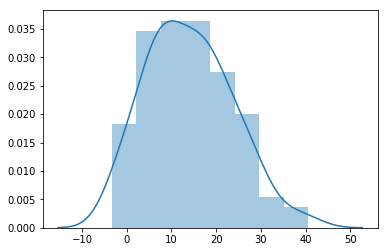

In [0]:
generate_data = [model(15).numpy() for i in range(100)]
sns.distplot(generate_data)

## Trace

In [0]:
sample_trace = trace(model).get_trace(15)
sample_trace.nodes

OrderedDict([('_INPUT',
              {'args': (15,), 'kwargs': {}, 'name': '_INPUT', 'type': 'args'}),
             ('temp',
              {'args': (),
               'cond_indep_stack': (),
               'continuation': None,
               'done': True,
               'fn': Normal(loc: 15.0, scale: 10.0),
               'infer': {},
               'is_observed': False,
               'kwargs': {},
               'mask': None,
               'name': 'temp',
               'scale': 1.0,
               'stop': False,
               'type': 'sample',
               'value': tensor(30.6752)}),
             ('sensor',
              {'args': (),
               'cond_indep_stack': (),
               'continuation': None,
               'done': True,
               'fn': Normal(loc: 30.675167083740234, scale: 1.0),
               'infer': {},
               'is_observed': False,
               'kwargs': {},
               'mask': None,
               'name': 'sensor',
               'scale'

In [0]:
sample_trace.log_prob_sum().exp()

tensor(0.0040)

## Condition on data

In [0]:
conditioned_model = pyro.condition(model , {'temp':30.6752 , 'sensor':31.2358})
trace(conditioned_model).get_trace(15).log_prob_sum().exp()

tensor(0.0040)

## Approxiamte ELBO

In [0]:
def mc_elbo(model , guide , data):
  guide_trace = trace(guide).get_trace(data)
  model_trace = trace(replay(model , guide_trace)).get_trace(data)
  return -1 * (model_trace.log_prob_sum() - guide_trace.log_prob_sum())

## Training

In [0]:
data = torch.from_numpy(np.array(generate_data))

In [0]:
def model(obs):
    temp = pyro.sample('temp', dist.Normal(0., 1.))
    
    with pyro.plate('local' ,len(obs)):
      sensor = pyro.sample('sensor', dist.Normal(temp, 1.0) , obs=obs)
    return sensor

In [0]:
def guide(obs):
  loc = pyro.param('loc' , torch.tensor(0.))
  scale = pyro.param('scale' , torch.tensor(1.) , constraint=constraints.positive)
  temp = pyro.sample('temp', dist.Normal(loc, scale))

In [0]:
pyro.clear_param_store()
elbo = Trace_ELBO()
optim = Adam({'lr': 1e-1})
svi = SVI(model, guide, optim, loss=elbo)

In [0]:
pyro.clear_param_store()
optim = Adam({'lr': 1e-1})
svi = SVI(model, guide, optim, loss=mc_elbo)

In [0]:
for _ in range(1000):
  loss = svi.step(data)

print(loss)

4706.078117609024


In [0]:
pyro.get_param_store()['loc']

tensor(13.8661, requires_grad=True)

In [0]:
pyro.get_param_store()['scale']

tensor(0.1686, grad_fn=<AddBackward0>)